# Formula 1 World Champion Early-Season Prediction 

## Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, balanced_accuracy_score,
    average_precision_score, precision_recall_curve, matthews_corrcoef
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.utils.class_weight import compute_sample_weight

## 2) Load Data

In [2]:
drivers = pd.read_csv("drivers.csv")
races = pd.read_csv("races.csv")
results = pd.read_csv("results.csv")
driver_standings = pd.read_csv("driver_standings.csv")
f1_2025_results = pd.read_csv("f1_2025_results.csv")

drivers["driverName"] = drivers["forename"].fillna("") + " " + drivers["surname"].fillna("")

### Number of race per year

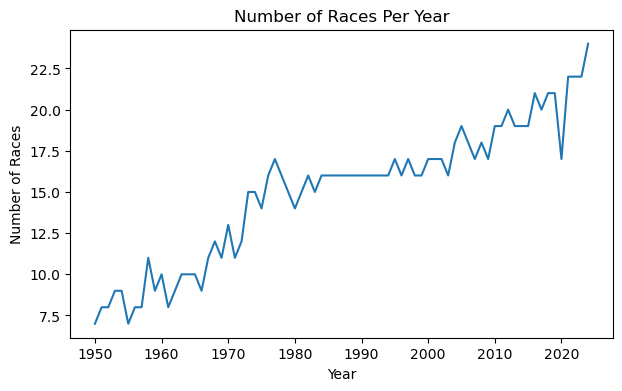

In [44]:
race_per_year = races.groupby("year").size()

plt.figure(figsize=(7,4))
plt.plot(race_per_year.index, race_per_year.values)
plt.title("Number of Races Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Races")
plt.show()


## 3) Feature Engineering (Early Season: first 9 races)
Create early-season driver performance features per year.


In [5]:
# Merge results with race info (year and round)
res = results.merge(races[["raceId", "year", "round"]], on="raceId")

# Keep only first 9 rounds
res_early = res[res["round"] < 10].copy()

res_early["positionOrder"] = pd.to_numeric(res_early["positionOrder"], errors="coerce")
res_early["points"] = pd.to_numeric(res_early["points"], errors="coerce").fillna(0)

res_early["is_win"] = (res_early["positionOrder"] == 1).astype(int)
res_early["is_podium"] = (res_early["positionOrder"].between(1, 3)).astype(int)

# Aggregate early season stats per driver-season
early_stats = res_early.groupby(["year", "driverId"], as_index=False).agg(
    wins=("is_win", "sum"),
    podiums=("is_podium", "sum"),
    races=("raceId", "count"),
    avg_finish=("positionOrder", "mean"),
    best_finish=("positionOrder", "min"),
    points=("points", "sum")
)

early_stats["win_rate"] = early_stats["wins"] / early_stats["races"]
early_stats["podium_rate"] = early_stats["podiums"] / early_stats["races"]


## 4) Create Champion Labels 

In [6]:
last_races = races.sort_values(["year", "round"]).groupby("year").tail(1)[["year", "raceId"]]

ds = driver_standings.merge(races[["raceId", "year"]], on="raceId")

final_standings = ds.merge(last_races, on=["year", "raceId"])
# Champion label
final_standings["position"] = pd.to_numeric(final_standings["position"], errors="coerce")
final_standings["champion"] = (final_standings["position"] == 1).astype(int)

## 5) Final Modeling Dataset (Features + Label)
Merge engineered early-season features with champion labels and apply basic filters.

In [7]:
# Combine features with champion label
data = early_stats.merge(
    final_standings[["year", "driverId", "champion"]],
    on=["year", "driverId"]
)

# Remove low-information records and invalid averages
data = data[data["races"] >= 3].dropna(subset=["avg_finish"]).copy()

# Exploratory Data Analysis (EDA)


## 6) Class Distribution (Champion vs Non-Champion)

### Class Distribution (Bar Graph) 

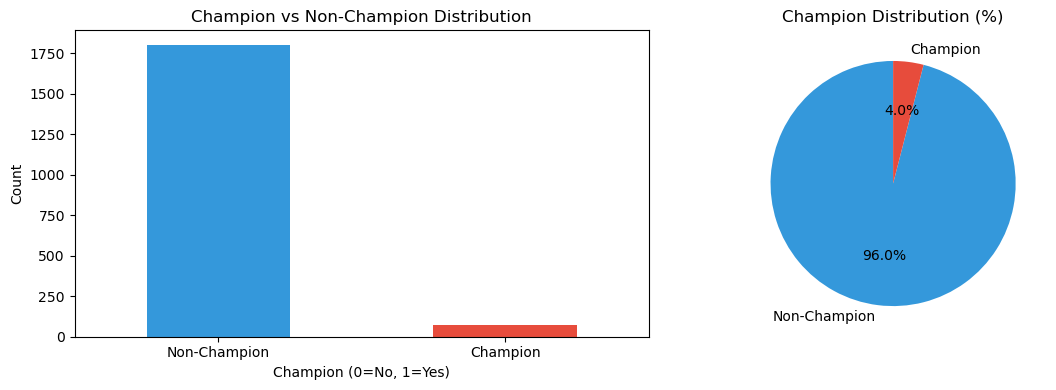

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

data["champion"].value_counts().plot(kind="bar", ax=axes[0], color=["#3498db", "#e74c3c"])
axes[0].set_title("Champion vs Non-Champion Distribution")
axes[0].set_xlabel("Champion (0=No, 1=Yes)")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(["Non-Champion", "Champion"], rotation=0)

champion_pct = data["champion"].value_counts(normalize=True) * 100
axes[1].pie(
    champion_pct,
    labels=["Non-Champion", "Champion"],
    autopct="%1.1f%%",
    colors=["#3498db", "#e74c3c"],
    startangle=90
)
axes[1].set_title("Champion Distribution (%)")

plt.tight_layout()
plt.show()

## 7) Feature Distributions by Champion Status


### Wins distribution

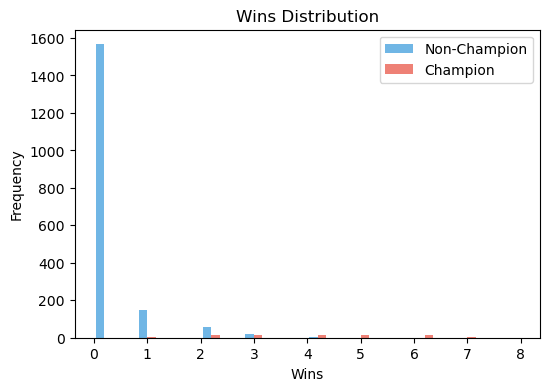

In [9]:
plt.figure(figsize=(6, 4))

champions = data[data["champion"] == 1]["wins"]
non_champions = data[data["champion"] == 0]["wins"]

plt.hist(
    [non_champions, champions],
    bins=20,
    label=["Non-Champion", "Champion"],
    color=["#3498db", "#e74c3c"],
    alpha=0.7
)

plt.title("Wins Distribution")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Podiums distribution

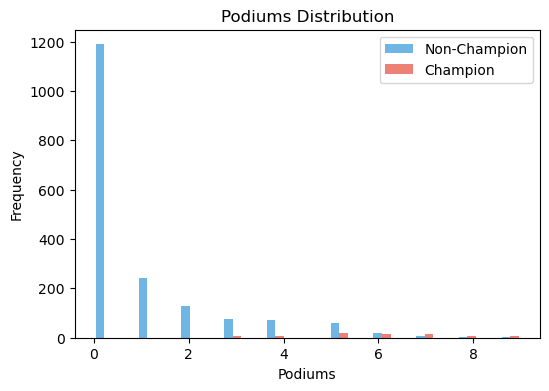

In [10]:
plt.figure(figsize=(6, 4))

champions = data[data["champion"] == 1]["podiums"]
non_champions = data[data["champion"] == 0]["podiums"]

plt.hist(
    [non_champions, champions],
    bins=20,
    label=["Non-Champion", "Champion"],
    color=["#3498db", "#e74c3c"],
    alpha=0.7
)

plt.title("Podiums Distribution")
plt.xlabel("Podiums")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Points distribution

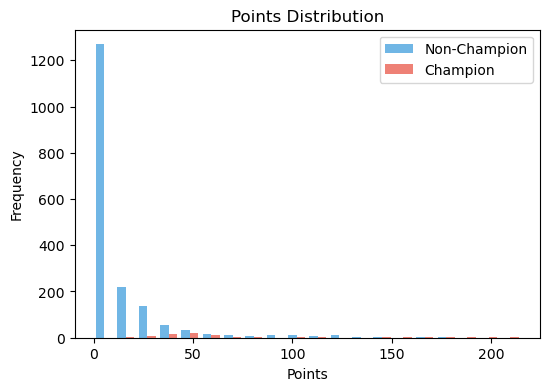

In [11]:
plt.figure(figsize=(6, 4))

champions = data[data["champion"] == 1]["points"]
non_champions = data[data["champion"] == 0]["points"]

plt.hist(
    [non_champions, champions],
    bins=20,
    label=["Non-Champion", "Champion"],
    color=["#3498db", "#e74c3c"],
    alpha=0.7
)

plt.title("Points Distribution")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Average finish distribution

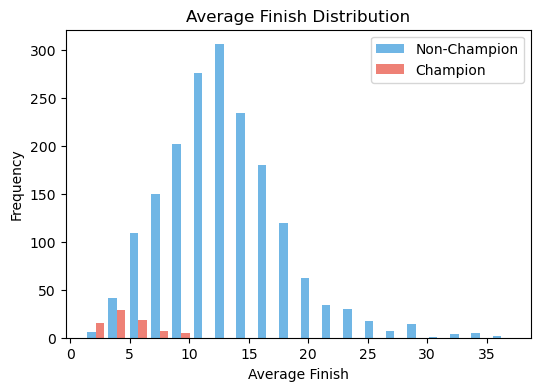

In [12]:
plt.figure(figsize=(6, 4))

champions = data[data["champion"] == 1]["avg_finish"]
non_champions = data[data["champion"] == 0]["avg_finish"]

plt.hist(
    [non_champions, champions],
    bins=20,
    label=["Non-Champion", "Champion"],
    color=["#3498db", "#e74c3c"],
    alpha=0.7
)

plt.title("Average Finish Distribution")
plt.xlabel("Average Finish")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## 8) Correlation Heatmap


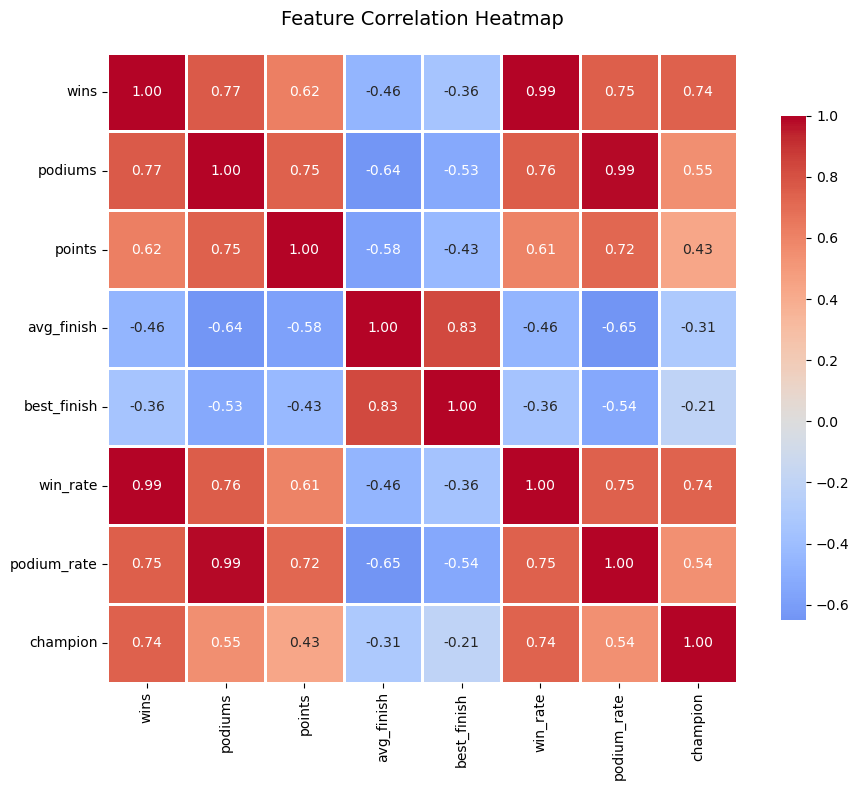

In [13]:
correlation_features = [
    "wins", "podiums", "points", "avg_finish", "best_finish",
    "win_rate", "podium_rate", "champion"
]
corr_matrix = data[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
    square=True, linewidths=1, cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation Heatmap", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


## 9) Scatter Plots (Key Relationships)


### Wins vs Points

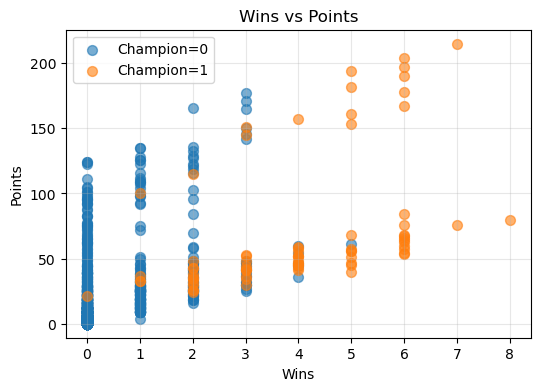

In [14]:
plt.figure(figsize=(6, 4))

for champion_val in [0, 1]:
    subset = data[data["champion"] == champion_val]
    plt.scatter(
        subset["wins"],
        subset["points"],
        label=f"Champion={champion_val}",
        alpha=0.6,
        s=50
    )

plt.xlabel("Wins")
plt.ylabel("Points")
plt.title("Wins vs Points")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Podiums vs Avg Finish

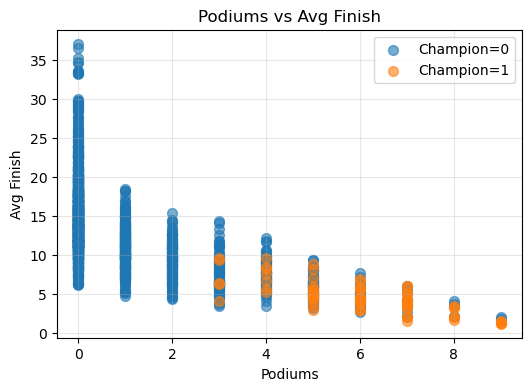

In [15]:
plt.figure(figsize=(6, 4))

for champion_val in [0, 1]:
    subset = data[data["champion"] == champion_val]
    plt.scatter(
        subset["podiums"],
        subset["avg_finish"],
        label=f"Champion={champion_val}",
        alpha=0.6,
        s=50
    )

plt.xlabel("Podiums")
plt.ylabel("Avg Finish")
plt.title("Podiums vs Avg Finish")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Win Rate vs Podium Rate

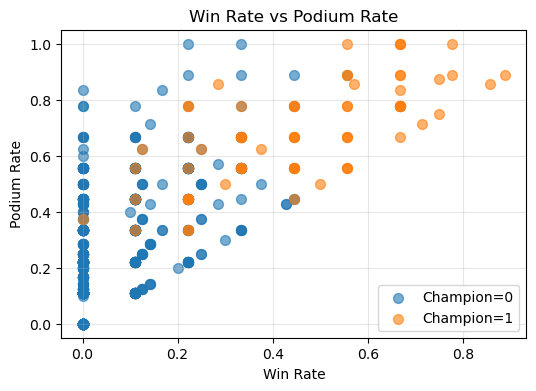

In [16]:
plt.figure(figsize=(6, 4))

for champion_val in [0, 1]:
    subset = data[data["champion"] == champion_val]
    plt.scatter(
        subset["win_rate"],
        subset["podium_rate"],
        label=f"Champion={champion_val}",
        alpha=0.6,
        s=50
    )

plt.xlabel("Win Rate")
plt.ylabel("Podium Rate")
plt.title("Win Rate vs Podium Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 10) Box Plots (Feature Comparison)


### Wins by champion status


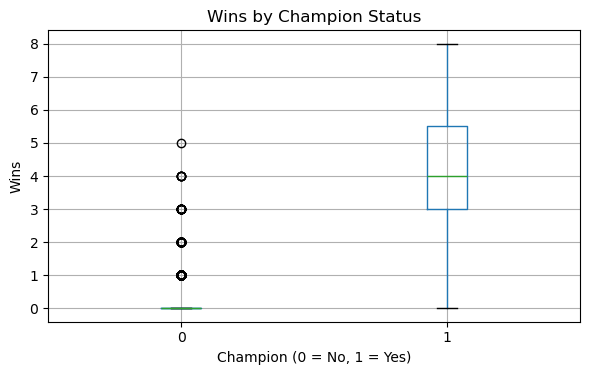

In [17]:
features_to_plot = [
    "points",
    "wins",
    "podiums",
    "best_finish",
    "avg_grid"
]


feature = features_to_plot[1]

fig, ax = plt.subplots(figsize=(6, 4))
data.boxplot(column=feature, by="champion", ax=ax)

ax.set_title(f"{feature.replace('_', ' ').title()} by Champion Status")
ax.set_xlabel("Champion (0 = No, 1 = Yes)")
ax.set_ylabel(feature.replace('_', ' ').title())

plt.suptitle("")
plt.tight_layout()
plt.show()

### Podiums by champion status

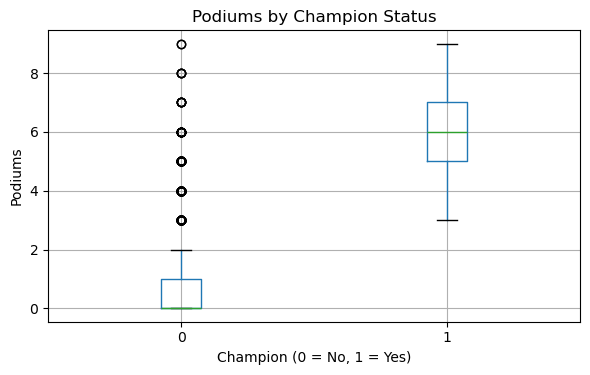

In [18]:
feature = features_to_plot[2]

fig, ax = plt.subplots(figsize=(6, 4))
data.boxplot(column=feature, by="champion", ax=ax)

ax.set_title(f"{feature.replace('_', ' ').title()} by Champion Status")
ax.set_xlabel("Champion (0 = No, 1 = Yes)")
ax.set_ylabel(feature.replace('_', ' ').title())

plt.suptitle("")
plt.tight_layout()
plt.show()

### Points by champion status

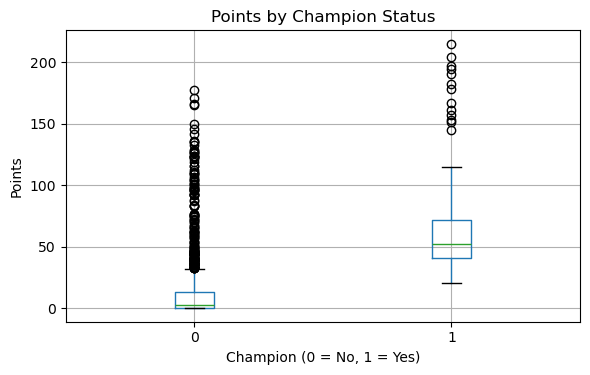

In [19]:
feature = features_to_plot[0]

fig, ax = plt.subplots(figsize=(6, 4))
data.boxplot(column=feature, by="champion", ax=ax)

ax.set_title(f"{feature.replace('_', ' ').title()} by Champion Status")
ax.set_xlabel("Champion (0 = No, 1 = Yes)")
ax.set_ylabel(feature.replace('_', ' ').title())

plt.suptitle("")
plt.tight_layout()
plt.show()

### Avg Finish by Champion Status

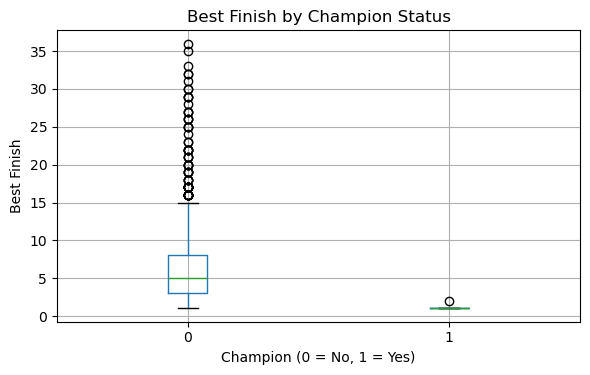

In [20]:
feature = features_to_plot[3]

fig, ax = plt.subplots(figsize=(6, 4))
data.boxplot(column=feature, by="champion", ax=ax)

ax.set_title(f"{feature.replace('_', ' ').title()} by Champion Status")
ax.set_xlabel("Champion (0 = No, 1 = Yes)")
ax.set_ylabel(feature.replace('_', ' ').title())

plt.suptitle("")
plt.tight_layout()
plt.show()

# Model Training and Evaluation


### Define Time-Based Train/Test Split

In [21]:
years = sorted(data["year"].unique())
split_year = years[-5] if len(years) >= 5 else years[int(len(years) * 0.8)]

train = data[data["year"] < split_year].copy()
test = data[data["year"] >= split_year].copy()


### Define Features (X) and Target (y)

In [22]:
# Feature set
features = ["wins", "podiums", "avg_finish", "best_finish", "win_rate"]

X_train = train[features]
y_train = train["champion"].astype(int)

X_test = test[features]
y_test = test["champion"].astype(int)

print("\nTrain years:", sorted(train["year"].unique())[-5:], 
      " ... total:", train["year"].nunique())

print("Test years:", sorted(test["year"].unique()), 
      " ... total:", test["year"].nunique())


Train years: [2015, 2016, 2017, 2018, 2019]  ... total: 70
Test years: [2020, 2021, 2022, 2023, 2024]  ... total: 5


## Fit All Three Models

### Logistic Regression

In [23]:
lr = LogisticRegression( class_weight="balanced", max_iter=1000, C=0.1, random_state=42 )
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42)

### Random Forest Classifier

In [24]:
rf = RandomForestClassifier( n_estimators=300, max_depth=8, min_samples_split=5, min_samples_leaf=2, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=300, random_state=42)

### Gradient Boosting Classifier

In [25]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [26]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Gradient Boosting": gb
}
fitted_models = models.copy()

## 13)  Evaluation Metrics

In [27]:
def evaluate_probs(y_true, y_pred, y_prob):
    out = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Acc": balanced_accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    }
    return out


In [28]:
cv_rows = []
gkf = GroupKFold(n_splits=min(5, train["year"].nunique()))

for name, model in models.items():
    y_true_all, y_prob_all = [], []

    for tr_idx, va_idx in gkf.split(X_train, y_train, groups=train["year"]):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # Balanced sample weights 
        sw = compute_sample_weight(class_weight="balanced", y=y_tr)

        if name == "Gradient Boosting":
            model.fit(X_tr, y_tr, sample_weight=sw)
        else:
            model.fit(X_tr, y_tr)

        prob = model.predict_proba(X_va)[:, 1]
        y_true_all.append(y_va.values)
        y_prob_all.append(prob)

    y_true_all = np.concatenate(y_true_all)
    y_prob_all = np.concatenate(y_prob_all)
    y_pred_all = (y_prob_all >= 0.5).astype(int)

    m = evaluate_probs(y_true_all, y_pred_all, y_prob_all)
    cv_rows.append({"Model": name, **m})

cv_df = pd.DataFrame(cv_rows).sort_values("F1", ascending=False)

print("\nCross-Validation ")
print(cv_df.round(4))

# Choose best model based on cross-validation F1 
best_model_name = cv_df.iloc[0]["Model"]
best_model = fitted_models[best_model_name]
print(f"\nBest model : {best_model_name}")


Cross-Validation 
                 Model  Accuracy  Balanced Acc  Precision  Recall      F1  \
1        Random Forest    0.9639        0.8579     0.5306  0.7429  0.6190   
2    Gradient Boosting    0.9594        0.8487     0.4904  0.7286  0.5862   
0  Logistic Regression    0.9335        0.9448     0.3681  0.9571  0.5317   

   ROC-AUC  
1   0.9717  
2   0.9627  
0   0.9850  

Best model : Random Forest


# 14) Evaluation Visualizations
Your original evaluation plots plus the Precision-Recall curve (useful for imbalanced classes).


### Model Performance Comparison (Bar Chart)

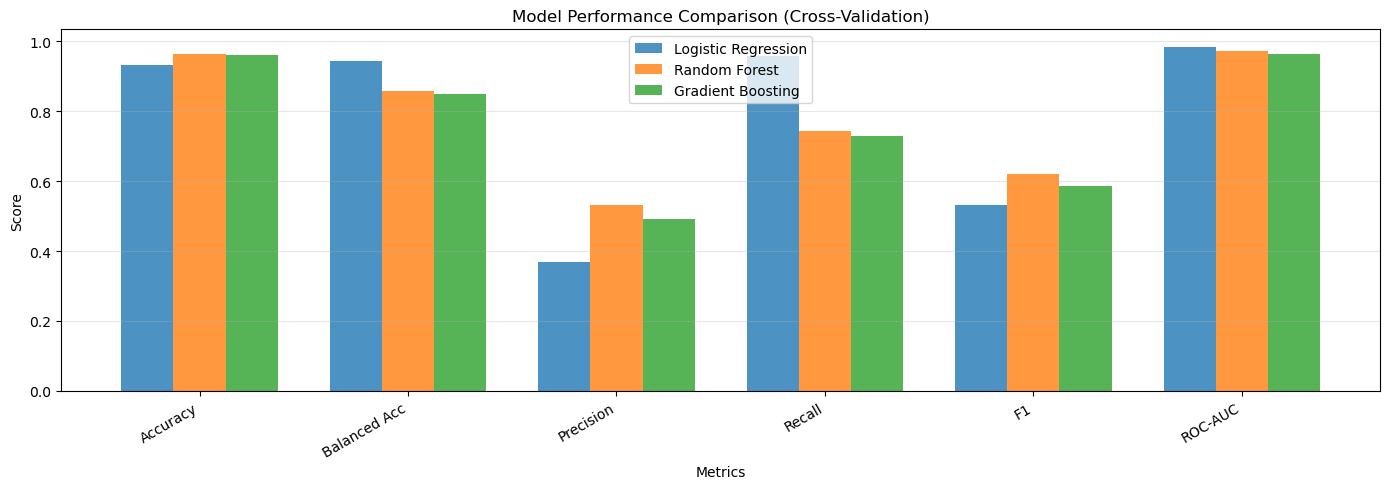

In [29]:
fig, ax = plt.subplots(figsize=(14, 5))

metrics = ["Accuracy", "Balanced Acc", "Precision", "Recall", "F1", "ROC-AUC"]
x_pos = np.arange(len(metrics))
width = 0.25

order = ["Logistic Regression", "Random Forest", "Gradient Boosting"]

for idx, model_name in enumerate(order):
    model_metrics = cv_df[cv_df["Model"] == model_name][metrics].values[0]
    offset = width * (idx - 1)
    ax.bar(x_pos + offset, model_metrics, width, label=model_name, alpha=0.8)

ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison (Cross-Validation)")
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics, rotation=30, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


### Detailed Model Metrics (Table)

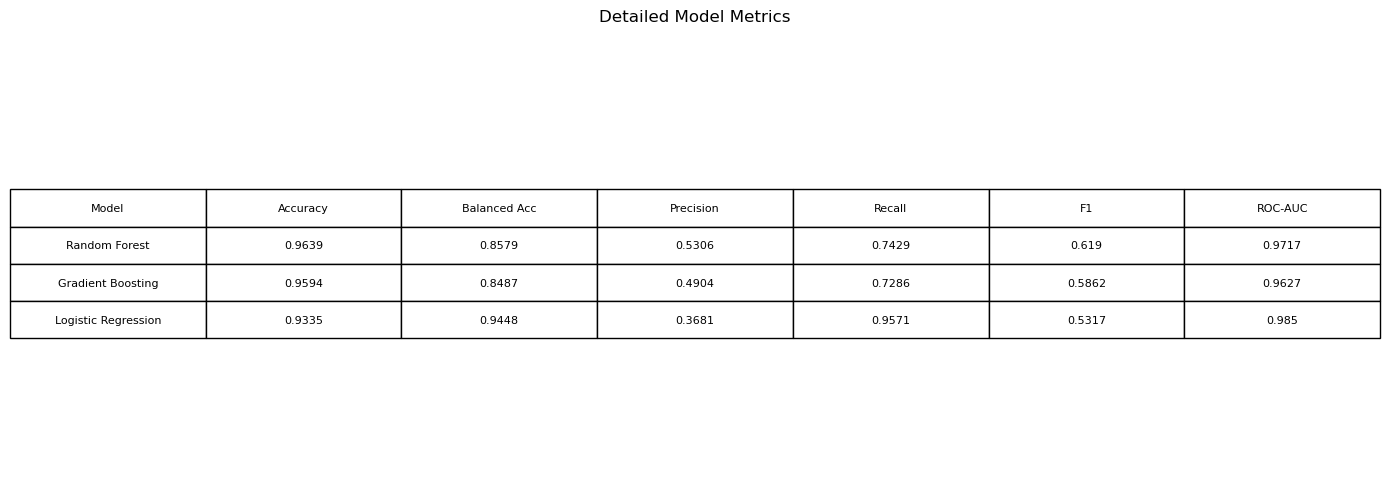

In [30]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.axis("tight")
ax.axis("off")

metrics = ["Accuracy", "Balanced Acc", "Precision", "Recall", "F1", "ROC-AUC"]
table_data = cv_df[["Model"] + metrics].round(4).values

table = ax.table(
    cellText=table_data,
    colLabels=["Model"] + metrics,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2)

ax.set_title("Detailed Model Metrics", pad=20)

plt.tight_layout()
plt.show()

## 15) Confusion Matrices

### Logistic Regression

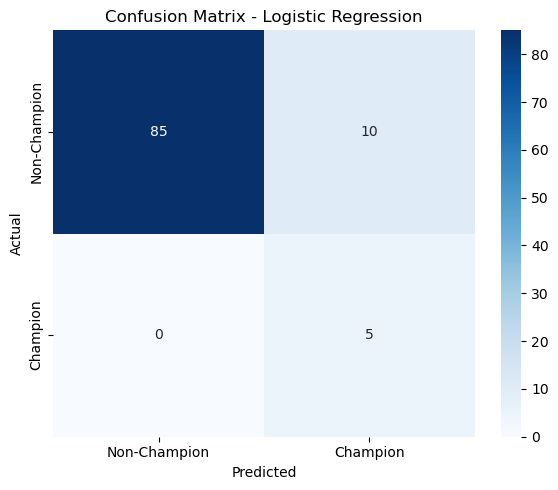

In [31]:
model_name = "Logistic Regression"
model = fitted_models[model_name]

y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Non-Champion", "Champion"],
    yticklabels=["Non-Champion", "Champion"]
)

plt.title(f"Confusion Matrix - {model_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


### Random Forest

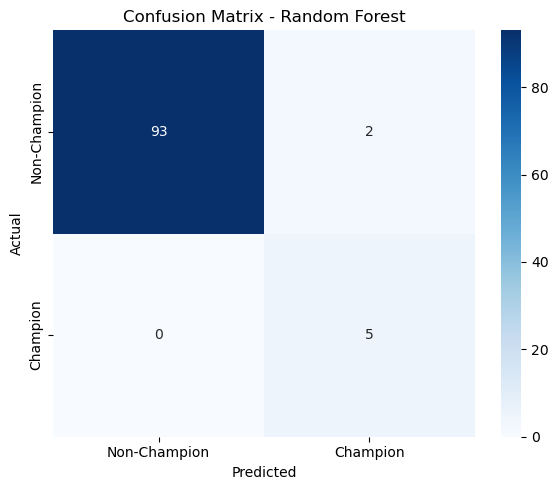

In [32]:
model_name = "Random Forest"
model = fitted_models[model_name]

y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Non-Champion", "Champion"],
    yticklabels=["Non-Champion", "Champion"]
)

plt.title(f"Confusion Matrix - {model_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


### Gradient Boosting

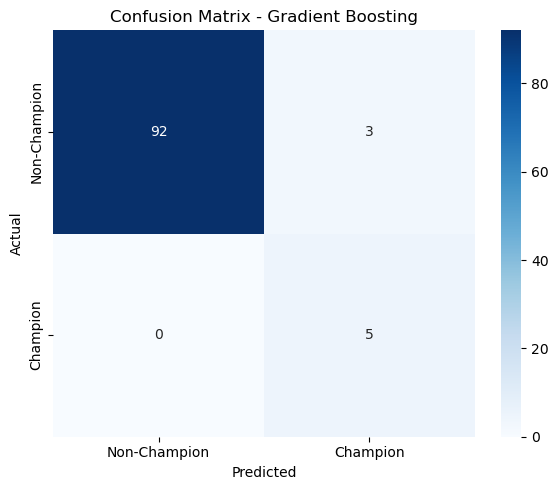

In [33]:
model_name = "Gradient Boosting"
model = fitted_models[model_name]

y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Non-Champion", "Champion"],
    yticklabels=["Non-Champion", "Champion"]
)

plt.title(f"Confusion Matrix - {model_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


### Feature Importance of Random Forest


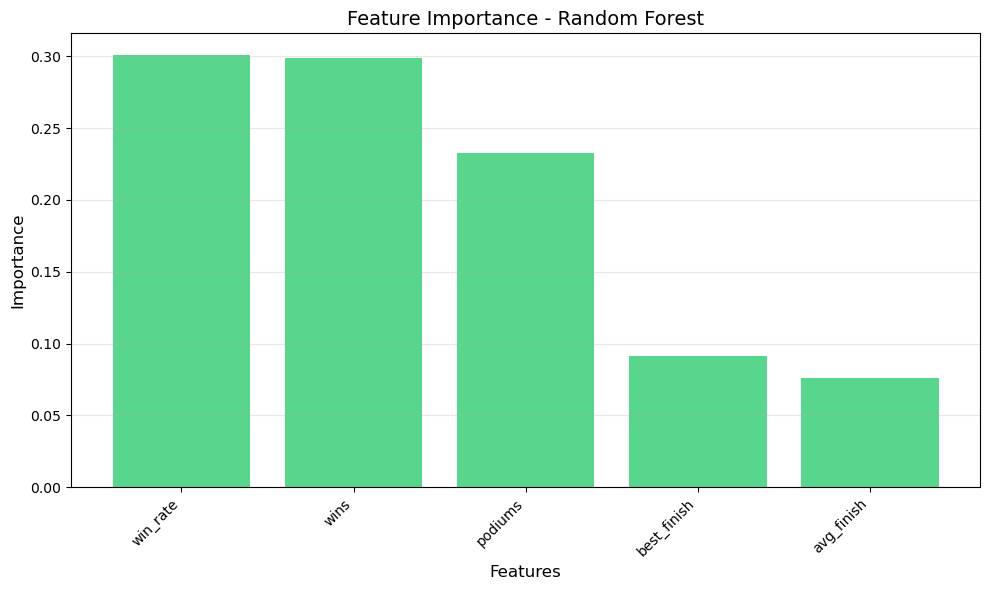

In [34]:
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(features)), importances[indices], color="#2ecc71", alpha=0.8)
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45, ha="right")
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Importance", fontsize=12)
    plt.title(f"Feature Importance - {best_model_name}", fontsize=14)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

### Predicted Probabilities Scatter Plot

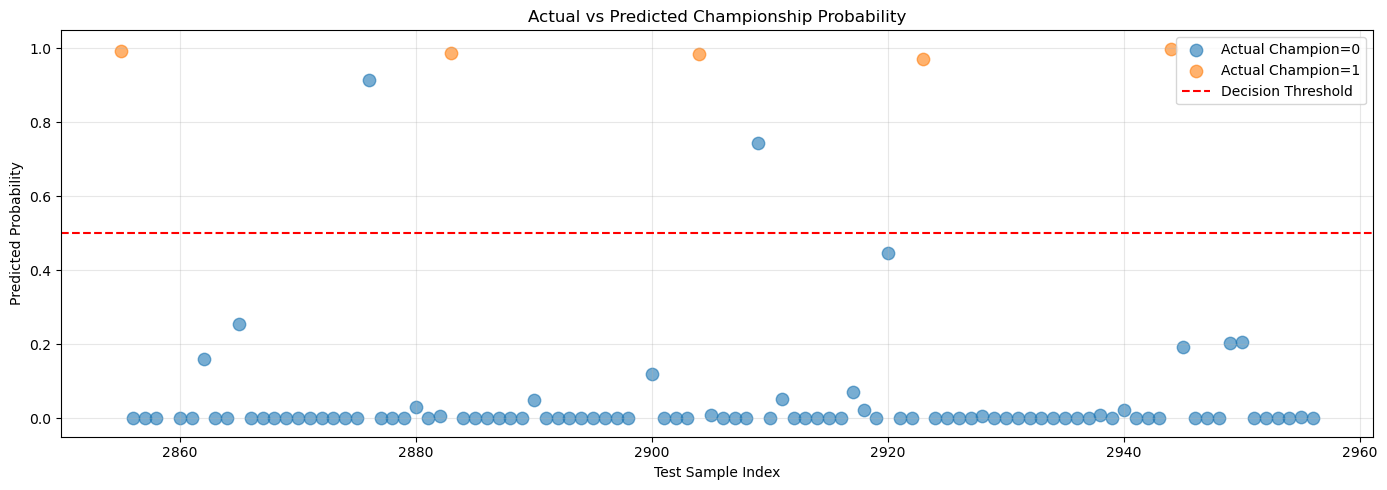

In [35]:
y_prob_best = best_model.predict_proba(X_test)[:, 1]
y_pred_best = (y_prob_best >= 0.5).astype(int)

test_with_pred = test.copy()
test_with_pred["predicted"] = y_pred_best
test_with_pred["probability"] = y_prob_best

plt.figure(figsize=(14, 5))

for actual_val in [0, 1]:
    subset = test_with_pred[test_with_pred["champion"] == actual_val]
    plt.scatter(
        subset.index,
        subset["probability"],
        label=f"Actual Champion={actual_val}",
        alpha=0.6,
        s=80
    )

plt.axhline(y=0.5, color="red", linestyle="--", label="Decision Threshold")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Probability")
plt.title("Actual vs Predicted Championship Probability")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 2025 Prediction (Early Season)
Build 2025 early-season features and predict champion probabilities using the best model.


### Build 2025 Features


In [36]:
tmp = f1_2025_results.copy()

if "round" in tmp.columns:
    tmp = tmp[tmp["round"] < 10]

tmp["position"] = pd.to_numeric(tmp["position"], errors="coerce")
tmp["is_win"] = (tmp["position"] == 1).astype(int)
tmp["is_podium"] = (tmp["position"].between(1, 3)).astype(int)

# Aggregate per driver for 2025 early season
feat_2025 = tmp.groupby("driver_name", as_index=False).agg(
    wins=("is_win", "sum"),
    podiums=("is_podium", "sum"),
    races=("race_name", "count"),
    avg_finish=("position", "mean"),
    best_finish=("position", "min")
)

feat_2025["win_rate"] = feat_2025["wins"] / feat_2025["races"]
feat_2025 = feat_2025[feat_2025["races"] >= 3].copy()


### Predict 2025 Champion Probabilities

In [37]:
X_2025 = feat_2025[features]
feat_2025["champion_prob"] = best_model.predict_proba(X_2025)[:, 1]
feat_2025 = feat_2025.sort_values("champion_prob", ascending=False)

print("\n2025 Championship Predictions:")
print(feat_2025[["driver_name", "wins", "podiums", "avg_finish", "champion_prob"]].head(10))



2025 Championship Predictions:
        driver_name  wins  podiums  avg_finish  champion_prob
20    Oscar Piastri     5       10    2.583333       0.814304
12     Lando Norris     4       10    3.500000       0.656805
15   Max Verstappen     2        5    5.166667       0.372778
7    George Russell     1        5    4.916667       0.124179
2   Charles Leclerc     0        4    6.833333       0.022452
0   Alexander Albon     0        0   11.000000       0.000000
21     Pierre Gasly     0        0   13.666667       0.000000
18   Oliver Bearman     0        0   12.545455       0.000000
17  Nico Hülkenberg     0        1   11.909091       0.000000
14      Liam Lawson     0        0   15.000000       0.000000


## 16) Visualize Top 10 Predictions (2025)

## Top 10 Championship Probabilities

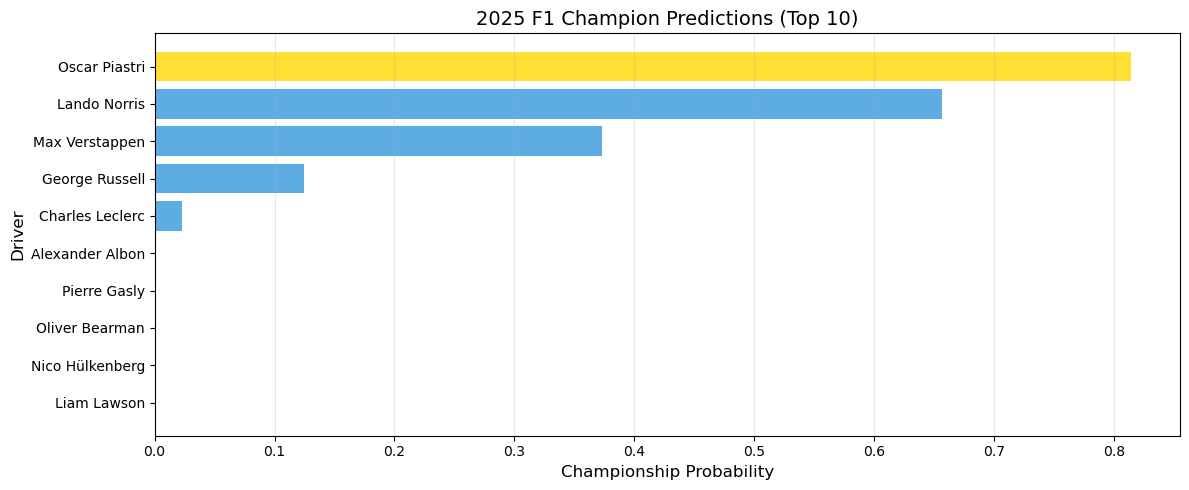

In [38]:
plt.figure(figsize=(12, 5))

top10 = feat_2025.head(10)
colors = ["gold" if i == 0 else "#3498db" for i in range(len(top10))]

plt.barh(
    top10["driver_name"],
    top10["champion_prob"],
    color=colors,
    alpha=0.8
)

plt.xlabel("Championship Probability", fontsize=12)
plt.ylabel("Driver", fontsize=12)
plt.title("2025 F1 Champion Predictions (Top 10)", fontsize=14)
plt.grid(axis="x", alpha=0.3)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()



In [39]:
winner = feat_2025.iloc[0]

print(f"\nPredicted 2025 Champion: {winner['driver_name']}")
print(f"Probability: {winner['champion_prob']:.2%}")
print(f"Wins: {winner['wins']}, Podiums: {winner['podiums']}, Avg Finish: {winner['avg_finish']:.2f}")



Predicted 2025 Champion: Oscar Piastri
Probability: 81.43%
Wins: 5, Podiums: 10, Avg Finish: 2.58
